# Dask Quantumtinkerer

## Introduction: making the dream calculation

Life is short and despite that we often find ourselves running long, expensive calculations. To speed things up, we can do a few things:
* Compile the code in C. 
* **Parallel** execution.

`Numba`/`CPython` allow us to easily convert our python code into C code - we already had a couple of good talks about them. Also, the good old [HPC05](https://gitlab.kwant-project.org/qt/init_hpc05) package allows us to run thing on the cluster.

In [30]:
import numpy as np
from numba import jit

x = np.arange(100).reshape(10, 10)


def slow_f(a):
    trace = 0.0
    for i in range(a.shape[0]):  # Numba likes loops
        trace += np.tanh(a[i, i])  # Numba likes NumPy functions
    return a + trace


@jit(nopython=True)  # Set "nopython" mode for best performance, equivalent to @njit
def fast_f(a):
    trace = 0.0
    for i in range(a.shape[0]):  # Numba likes loops
        trace += np.tanh(a[i, i])  # Numba likes NumPy functions
    return a + trace

In [31]:
%%timeit -n 1000
slow_f(x)

27.9 µs ± 6.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
%%timeit -n 1000
fast_f(x)

2.7 µs ± 368 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


See more on [Numba's documentation](https://numba.readthedocs.io/en/stable/user/5minguide.html).

There are more ways to increase the efficiency of your calculation:
* Splitting data into chunks to efficiently utilize memory.
* Asynchronous and parallel I/O.
* Dynamic task scheduling.

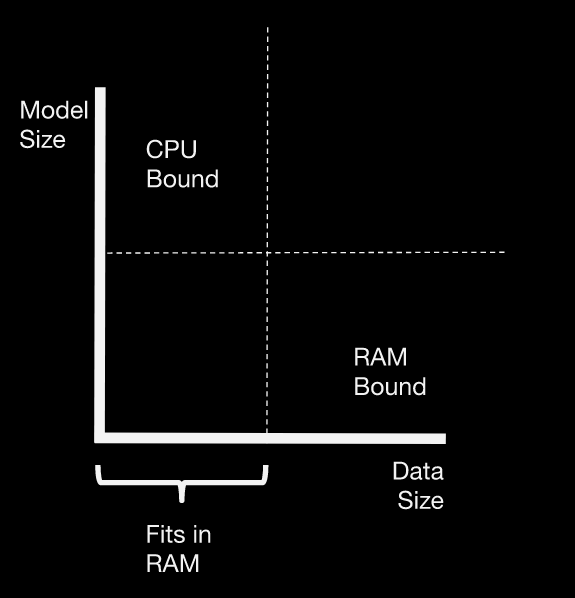

All of these are cool, but require a lot of thinking when designing your code. However, we don't need to think about it - [Dask](https://tutorial.dask.org/00_overview.html) does it all for us!

## What is Dask?

### Parallelisation with `dask.delayed`

In [38]:
from time import sleep


def inc(x):
    sleep(1)
    return x + 1


def add(x, y):
    sleep(1)
    return x + y

In [39]:
%%time
x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 2.88 ms, sys: 1.03 ms, total: 3.92 ms
Wall time: 3 s


In [43]:
%%time
from dask import delayed

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 2.36 ms, sys: 1.03 ms, total: 3.39 ms
Wall time: 2.62 ms


In [44]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 4.25 ms, sys: 4.14 ms, total: 8.39 ms
Wall time: 2.01 s


5

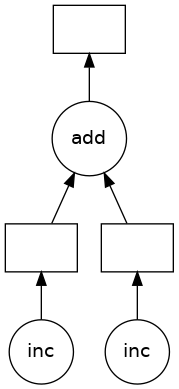

In [45]:
z.visualize()

In [46]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [47]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)

CPU times: user 1.28 ms, sys: 2.44 ms, total: 3.72 ms
Wall time: 8.01 s


In [48]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-18d53e0e-8af7-44d0-8b88-982404e15700')
After computing : 44
CPU times: user 10.5 ms, sys: 10.3 ms, total: 20.7 ms
Wall time: 1.01 s


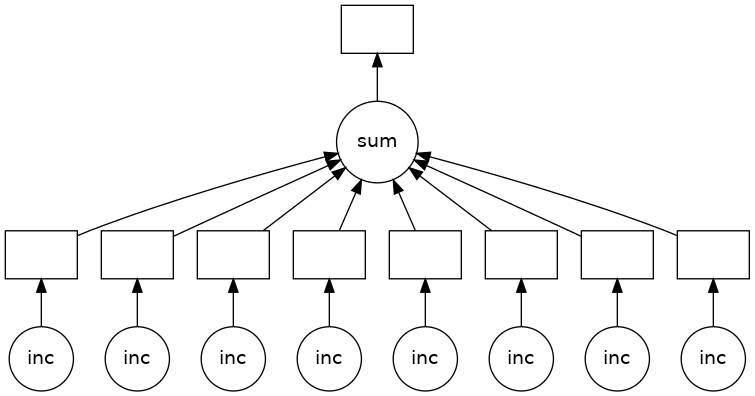

In [49]:
total.visualize()

### Data chunking with `dask.array`

In [505]:
import dask.array as da

In [506]:
x = da.random.normal(10, 0.1, size=(4, 4), chunks=(2, 2))
x

dask.array<normal, shape=(4, 4), dtype=float64, chunksize=(2, 2), chunktype=numpy.ndarray>

In [507]:
x[0, 0]

dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

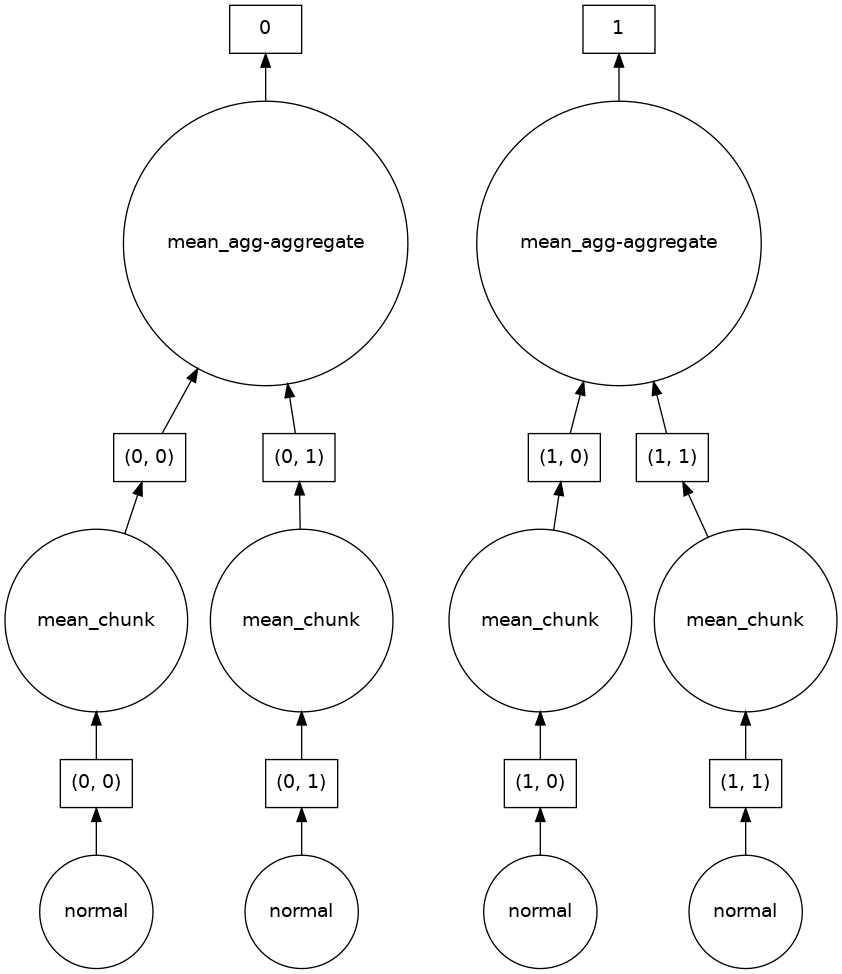

In [508]:
x.mean(axis=1).visualize()

In [509]:
y = da.random.normal(10, 0.1, size=(4, 4), chunks=(2, 2))

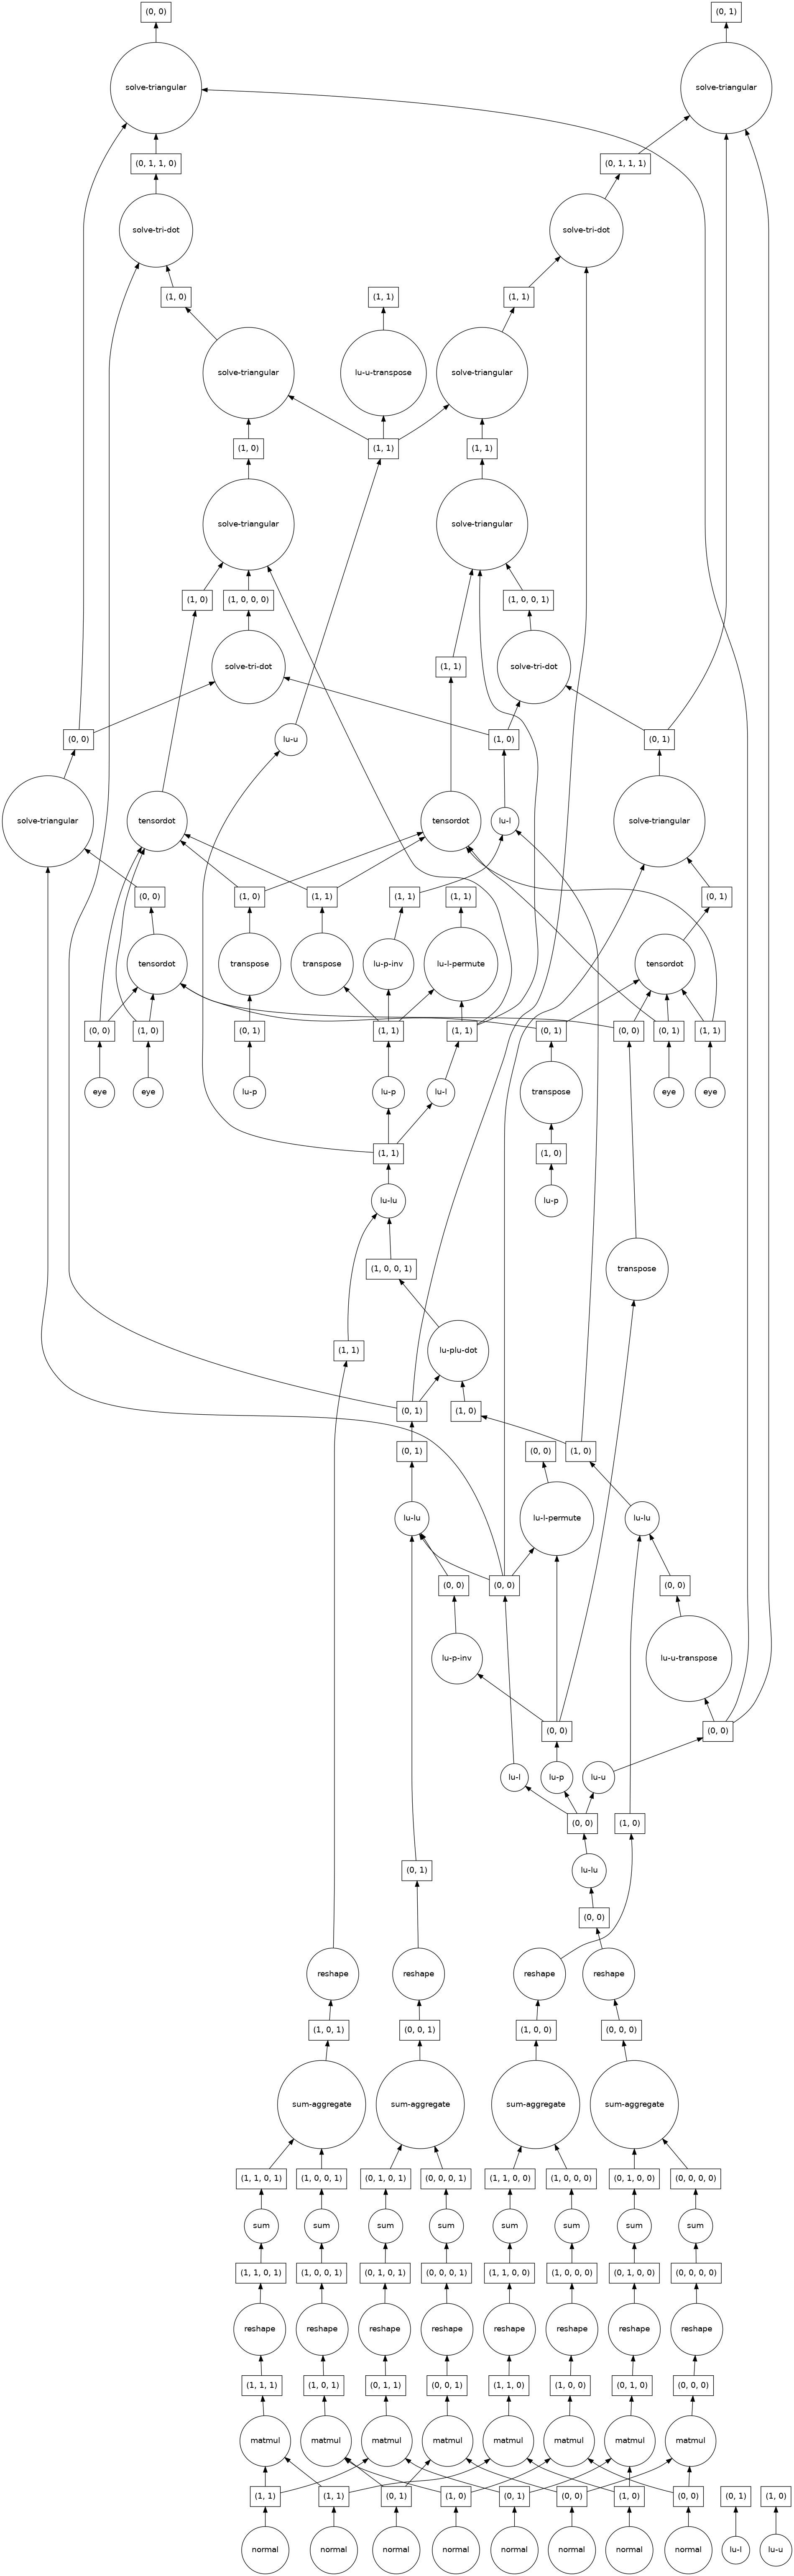

In [510]:
inv = da.linalg.inv(x @ y)
inv.visualize()

### I/O with chunked data

Dask supports writing and reading chunks in parallel. This means that you never have to load the full data into memory during I/O.

The most common file format you'll find using are HDF5, netCDF, zarr.

In [515]:
inv

dask.array<solve-triangular, shape=(4, 4), dtype=float64, chunksize=(2, 2), chunktype=numpy.ndarray>

In [519]:
inv.to_zarr("invere_matrix", overwrite=True)

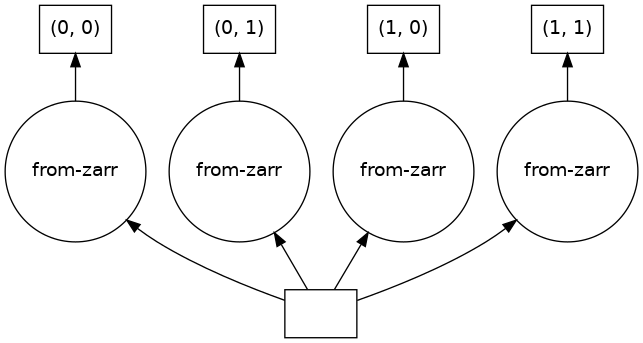

In [523]:
loaded_zarr = da.from_zarr("invere_matrix")
loaded_zarr.visualize()

## Using the cluster with `dask_quantumtinkerer`

### Prerequisites
1. You must be able to ssh hpc05 without a password ([detailed instructions here](https://gitlab.kwant-project.org/qt/cookbook/-/blob/master/hpc05/README.md)).
2. On IO, uncomment all lines in the file~/.config/dask/quantumtinkerer.yaml (it should appear automatically, if not -- restart your Jupyterhub notebook) and edit the gateway_port option. This is a TCP port number), that must be unique for you. A random number between 10000 and 40000 should be good.
3. Restart your notebook.

In [542]:
from dask_quantumtinkerer import Cluster, cluster_options

In [543]:
options = cluster_options()
options

In [544]:
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/kostasvilkelis/work/"  # Make sure to do this if you import any local modules!

To utilize local modules imported in this notebook, you need to specify the path in hpc05 to the import.
Make sure to sync your code on io and hpc05 (through git)!

In [545]:
cluster = Cluster(options)
cluster

We can use the dashboard to monitor the progress of the calculation and obtain valuable information (we shall see that later).

To access it, take the `8000/clusters/.../status` part from above dashboard link and combine it with io proxy link as shown below:

In [672]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/Kostas/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/Kostas/proxy/8000/clusters/3377176a5a3843b39d1581194880db9c/status


We have logged into the cluster, however, we still have no workers connected. There are two ways to connect/scale the workers:
* **Manual scaling**: you connect to a fixed number of workers right until you disconnect from the cluster.
* **Adaptive scaling**: workers scale adaptively based on the calculation you are running.

In [ ]:
cluster.scale(10)

In [ ]:
cluster.adapt(minimum=0, maximum=10)

In [665]:
import time


@delayed
def do_nothing(x):
    time.sleep(5)
    return x


x = da.concatenate(
    [da.from_delayed(do_nothing(i), shape=(1,), dtype=int) for i in range(10)]
)

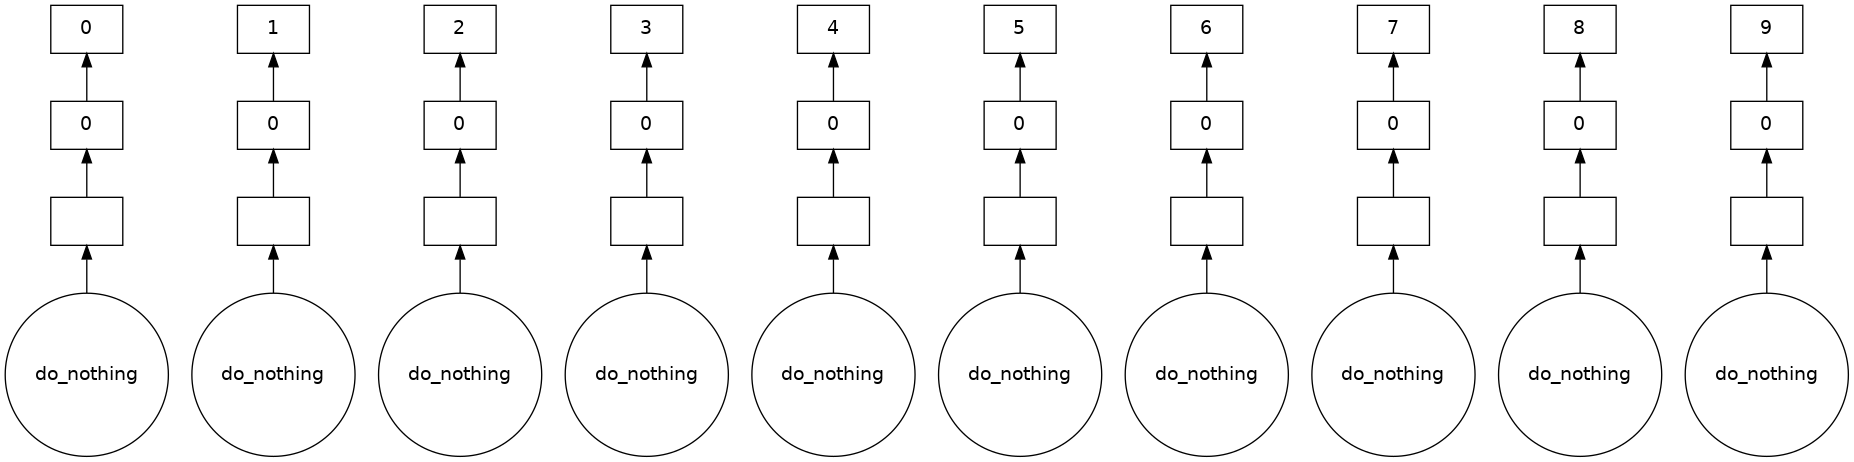

In [662]:
x.visualize()

In [670]:
x.compute()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In order to utilize the cluster, we need to run the `cluster.get_client()` command. This makes it so that all subsequent calls for `compute()` or `persist()` get transferred over to the cluster

In [641]:
client = cluster.get_client()

x.compute()

The other command I mentioned, `persist()`, is the same as compute, only difference is that after calculations it leaves the data distributed all over the workers.

In [666]:
x_distr = x.persist()

In [667]:
x_distr

dask.array<concatenate, shape=(10,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>

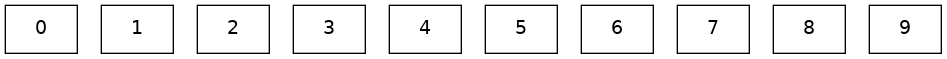

In [668]:
x_distr.visualize()

In [674]:
cluster.close()

Some things you **need** to make sure of before running the calculation:

* Worker Memory $>$ Chunk Size (+account for memory usage from the task itself)

* #Cores  $\leq$ #Chunks 

*  Chunk Size s.t. Task on that chunk takes $\geq$ 100ms

# Walktrough example: Calculation, storage, analysis

In [1]:
from dask_quantumtinkerer import Cluster, cluster_options
import numpy as np
from time import sleep
from random import random
import zarr
import itertools as it
import dask
import dask.array as da

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
#Classic adaptive ring example
def f(x, y, a):
    sleep(30*random())
    return x + np.exp(-(x**2 + y**2 - 0.75**2)**2/a**4)

N = 40
params = {
    "x": np.linspace(-1.0, 1.0, N),
    "y": np.linspace(-1.0, 1.0, N),
    "a" : np.array([0.2, 0.6])
}

In [5]:
values = list(params.values())
args = np.array(list(it.product(*values)))
shapes = [len(values[i]) for i in range(len(values))]

def wrapped_fn(args):
    return f(*args)

In [6]:
options = cluster_options()
options.worker_memory = 2
options.extra_path = "/home/kostasvilkelis/work/qt-dask-demo/"


cluster = Cluster(options)
#cluster.adapt(minimum=0, maximum=10)
cluster.scale(10)
print('http://io.quantumtinkerer.tudelft.nl/user/Kostas/proxy/' +
      cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/Kostas/proxy/8000/clusters/c2bcd1b77bbe4e41a598cbe2a87cfc29/status


In [7]:
client = cluster.get_client()

In [ ]:
import dask.dataframe as df

In [9]:
da_args = da.from_array(args.T, chunks=(3, 100))
results = da_args.map_blocks(wrapped_fn, dtype=float, drop_axis=0)

In [10]:
df.from_dask_array(results).to_hdf('ok*', 'no')

NameError: name 'df' is not defined

In [279]:
results.compute()

array([-1.        , -0.99999988, -1.        , ...,  1.00000101,
        1.        ,  1.00000012])

In [257]:
x = np.reshape(results.compute(), shapes)

In [258]:
import xarray as xr

In [264]:
xr_array = xr.DataArray(data=x,
                        dims=params.keys(),
                        coords=params,
                        attrs={'description' : 'Ring Example'})

In [266]:
xr_array

<xarray.DataArray (x: 40, y: 40, a: 2)>
array([[[-1.        , -0.99999988],
        [-1.        , -0.99999899],
        [-1.        , -0.99999334],
        ...,
        [-1.        , -0.99999334],
        [-1.        , -0.99999899],
        [-1.        , -0.99999988]],

       [[-0.94871795, -0.94871694],
        [-0.94871795, -0.94871058],
        [-0.94871795, -0.94867603],
        ...,
        [-0.94871795, -0.94867603],
        [-0.94871795, -0.94871058],
        [-0.94871795, -0.94871694]],

       [[-0.8974359 , -0.89742924],
        [-0.8974359 , -0.89739398],
        [-0.8974359 , -0.89722814],
        ...,
...
        ...,
        [ 0.8974359 ,  0.89764366],
        [ 0.8974359 ,  0.89747781],
        [ 0.8974359 ,  0.89744256]],

       [[ 0.94871795,  0.94871896],
        [ 0.94871795,  0.94872531],
        [ 0.94871795,  0.94875986],
        ...,
        [ 0.94871795,  0.94875986],
        [ 0.94871795,  0.94872531],
        [ 0.94871795,  0.94871896]],

       [[ 1.        ,  1.00000012],
        [ 1.        ,  1.00000101],
        [ 1.        ,  1.00000666],
        ...,
        [ 1.        ,  1.00000666],
        [ 1.        ,  1.00000101],
        [ 1.        ,  1.00000012]]])
Coordinates:
  * x        (x) float64 -1.0 -0.9487 -0.8974 -0.8462 ... 0.8974 0.9487 1.0
  * y        (y) float64 -1.0 -0.9487 -0.8974 -0.8462 ... 0.8974 0.9487 1.0
  * a        (a) float64 0.2 0.6
Attributes:
    description:  Ring Example

In [265]:
%matplotlib inline
import holoviews as hv
from holoviews import opts
hv.extension("matplotlib")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [262]:
hv_data = hv.Dataset(xr_array.to_dataset(name='value'))

:DynamicMap   [a]
   :Image   [x,y]   (value)
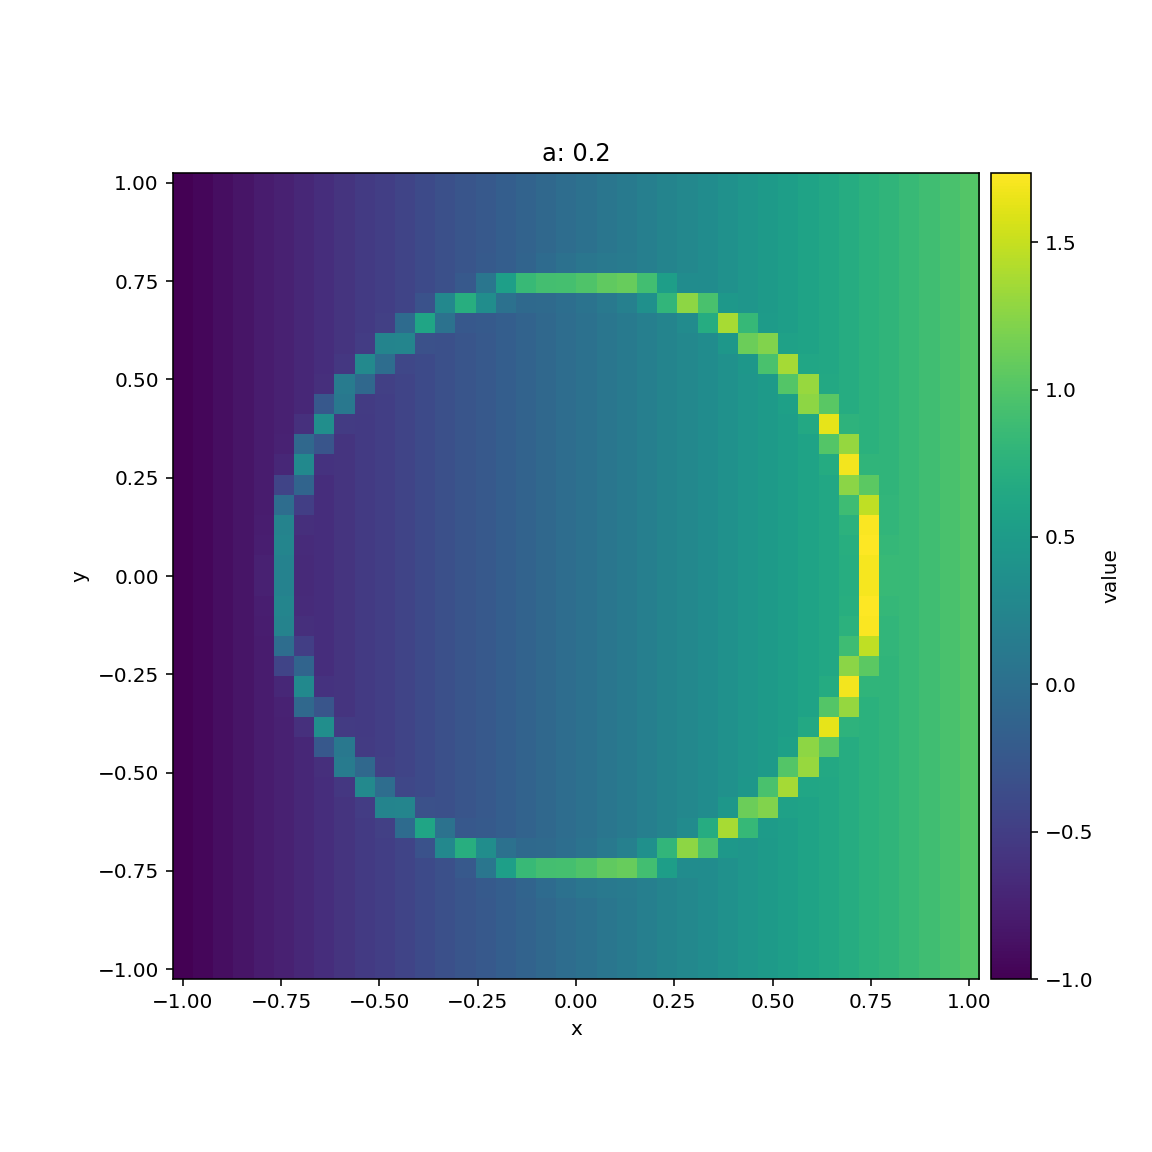

In [263]:
dmap = (
    hv_data.to(hv.Image, kdims=["x", "y"], dynamic=True)
    .opts(cmap="viridis")
    .opts(plot=dict(colorbar=True, fig_size=200, aspect="square"))
)
dmap

:DynamicMap   [y,a]
   :Curve   [x]   (value)
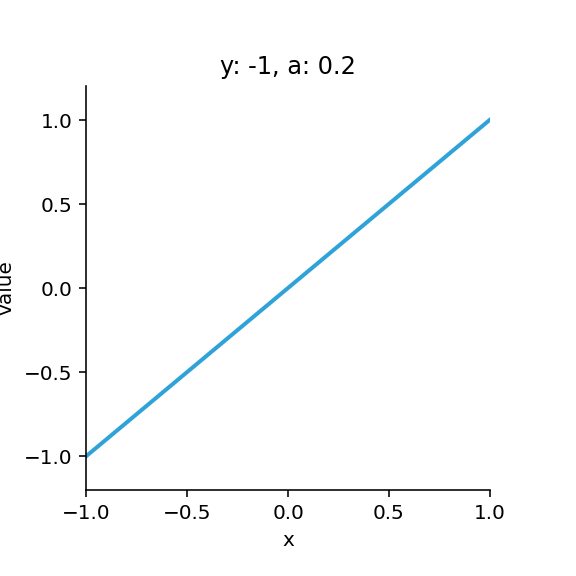

In [267]:
dmap = hv_data.to(hv.Curve, kdims=["x"], dynamic=True)
dmap